# LIBRERÍAS Y PREPARACIÓN DATASET

In [1]:
# importar las librerías requeridas
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from keras.layers import Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import os
import glob
import time
#Importar librería de google drive para la carga de los archivos de datos requeridos.
from google.colab import drive

from statsmodels.graphics.tsaplots import plot_acf


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import math
from sklearn.metrics import mean_squared_error, r2_score

import plotly.graph_objs as go



Definiciones

In [2]:
entrenamiento='2023-12-31'
#validacion='2023-12-31'
pruebas='2024-03-31'

lookback = 168 # Número de pasos hacia atrás
steps_ahead=168 # Número de pasos adelante
blackout=168
features=28
excluir_demanda=1 # 0 para no excluir, 1 para si excluir
epochs=30
batch_size=10
semanas_test=13
patience=5
future_features=10


Importar el dataset

In [3]:

drive.mount('/content/drive')

# Se crea un path específico para facilitar la lectura de los archivos posteriormente desde google drive
path = "/content/drive/MyDrive/seminario-master/Datasets_salida/"

dataset=pd.read_csv(path + 'dataset_final/dataset_demada_Antioquia.csv', sep=',')



#Normalizar datos negativos
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_pond'] < 0, 'ALLSKY_SFC_SW_DWN_pond'] = 0
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_BAJO CAUCA'] < 0, 'ALLSKY_SFC_SW_DWN_BAJO CAUCA'] = 0
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_URABA'] < 0, 'ALLSKY_SFC_SW_DWN_URABA'] = 0

dataset['FECHA'] = pd.to_datetime(dataset['FECHA'])

# Establecemos la columna 'FECHA' como el índice del DataFrame
dataset.set_index('FECHA', inplace=True)

dataset=dataset['2021-01-04':pruebas]

dataset.tail()


Mounted at /content/drive


,TIPO DIA,AÑO,MES,DIA,HORA,DEMANDA,Demanda_anterior,Total Residencial,Total No Residencial,Industrial,...,T2M_BAJO CAUCA,T2M_MAGDALENA MEDIO,T2M_NORDESTE,T2M_NORTE,T2M_OCCIDENTE,T2M_ORIENTE,T2M_SUROESTE,T2M_URABA,Date,PRECIO BOLSA
FECHA,,,,,,,,,,,,,,,,,,,,,
2024-03-31,DSS,2024,3,31,19,1236.59484,1211.76245,2390634.0,221389.0,25767.0,...,24.320000,22.946667,21.115455,17.864667,17.882632,19.6500,18.895909,25.692727,NaN,NaN
2024-03-31,DSS,2024,3,31,20,1194.09246,1236.59484,2390634.0,221389.0,25767.0,...,23.993333,22.688333,20.654545,17.600667,17.654211,19.3105,18.709545,25.538182,NaN,NaN
2024-03-31,DSS,2024,3,31,21,1135.40287,1194.09246,2390634.0,221389.0,25767.0,...,23.760000,22.533333,20.313636,17.324000,17.377895,18.9805,18.477273,25.342727,NaN,NaN
2024-03-31,DSS,2024,3,31,22,1070.30015,1135.40287,2390634.0,221389.0,25767.0,...,23.526667,22.363333,19.900909,16.968000,17.078421,18.6690,18.210909,25.177273,NaN,NaN
2024-03-31,DSS,2024,3,31,23,977.81669,1070.30015,2390634.0,221389.0,25767.0,...,23.306667,21.998333,19.523636,16.639333,16.781579,18.3995,17.855455,25.007273,NaN,NaN


Clasificación por tipo de día

In [4]:
# Definir una función para mapear los valores de 'TIPO DIA' a 'T_DIA'
def map_tipo_dia(tipo_dia):
    if tipo_dia in ['MARTES', 'MIERCOLES','MIÉRCOLES', 'JUEVES', 'VIERNES', 'MSS']:
        return 'MAR-VIE'
    elif tipo_dia in ['DOMINGO', 'DOALF', 'DOALFENE', 'DOVDIC', 'DOVENE', 'DSS', 'JSS', 'VSS']:
        return 'DOM'
    elif tipo_dia in ['SABADO','SÁBADO', 'SAALF','SSS', 'SAALFENE', 'SAVDIC', 'SAVENE', '24--DIC', '31--DIC']:
        return 'SAB'
    elif tipo_dia in ['LF', 'LFENE']:
        return 'LFEST'
    elif tipo_dia in ['1--MAY', '20--JUL', '7--AGO', '8--DIC']:
        return 'OFEST'
    elif tipo_dia in ['25--DIC', '1--ENE']:
        return '25-1'
    elif tipo_dia in ['MAVDIC' , 'MAVENE', 'MIVDIC', 'MIVENE', 'JUVDIC','JUVENE','VIVDIC','VIVENE']:
        return 'MV-DE'
    elif tipo_dia in ['LUVDIC', 'LUVENE']:
        return 'L-DE'
    elif tipo_dia in ['LUNES', 'MADLF']:
        return 'LUN-MADLF'
    else:
        return tipo_dia

# Aplicar la función a la columna 'TIPO DIA' para crear la nueva columna 'T_DIA'
dataset['T_DIA'] = dataset['TIPO DIA'].apply(map_tipo_dia)


In [5]:
dataset['T_DIA_PRED']=''

In [6]:
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('T_DIA_PRED')] = dataset[(blackout+steps_ahead):]['T_DIA']

In [7]:
dataset['T_DIA_PRED'].unique()

array(['LUN-MADLF', 'MAR-VIE', 'SAB', 'DOM', 'LFEST', 'OFEST', 'MV-DE',
       'L-DE', '25-1', '2--ENE', ''], dtype=object)

In [8]:
dataset[['T_DIA', 'T_DIA_PRED']].head(50)

,T_DIA,T_DIA_PRED
FECHA,,
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF
2021-01-04,L-DE,LUN-MADLF


In [9]:
dataset['Date'] = dataset.index
# Supongamos que tu DataFrame se llama 'dataset' y la serie temporal que quieres analizar está en la columna 'DEMANDA'

# Asegúrate de que la columna 'Date' esté en formato de fecha
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Obtener los valores únicos de T_DIA
unique_t_dia = dataset['T_DIA'].unique()
# Crear un diccionario para almacenar los DataFrames filtrados
filtered_datasets = {}
filtered_datasets_list = []



# Iterar sobre los diferentes valores de T_DIA
for t_dia in unique_t_dia:
    # Filtrar los datos para el valor actual de T_DIA
    filtered_demand = dataset[dataset['T_DIA'] == t_dia]
    filtered_demand.loc[:, 'Date'] = pd.to_datetime(filtered_demand['Date'])
    filtered_demand = filtered_demand.reset_index(drop=True)

    # Crear una nueva columna llamada 'Delta_24h'
    filtered_demand['Delta_24h'] = filtered_demand['DEMANDA'].shift(24)
    # Crear una nueva columna llamada 'Delta_25h'
    filtered_demand['Delta_25h'] = filtered_demand['Demanda_anterior'].shift(24)



    # Establecer el valor de 'Delta_24h' y 'Delta_25h' para los primeros 24 registros
    for i in range(24):
        filtered_demand.at[i, 'Delta_24h'] = filtered_demand.at[i, 'DEMANDA']
        filtered_demand.at[i, 'Delta_25h'] = filtered_demand.at[i, 'Demanda_anterior']

    # Establecer el valor de 'Delta_25h' para el registro 25
    filtered_demand.at[24, 'Delta_25h'] = filtered_demand.at[24, 'Demanda_anterior']



    # Normalizar las características numéricas
    #scaler = StandardScaler()
    #filtered_demand[numeric_columns] = scaler.fit_transform(filtered_demand[numeric_columns])

    # Almacenar el DataFrame filtrado en el diccionario
    filtered_datasets[t_dia] = filtered_demand
    filtered_datasets_list.append(filtered_demand)


# Concatenar los DataFrames en un solo conjunto de datos
final_dataset = pd.concat(filtered_datasets_list, ignore_index=True)

final_dataset = final_dataset.sort_values(by=['AÑO', 'MES', 'DIA', 'HORA'], ascending=True)

dataset=final_dataset
dataset.set_index('Date', inplace=True)
dataset.columns

Index(['TIPO DIA', 'AÑO', 'MES', 'DIA', 'HORA', 'DEMANDA', 'Demanda_anterior',
       'Total Residencial', 'Total No Residencial', 'Industrial',
       'total_usuarios', 'ALLSKY_SFC_SW_DWN_pond', 'ALLSKY_KT_pond',
       'T2M_pond', 'RH2M_pond', 'PRECTOTCORR_pond', 'CLRSKY_SFC_SW_DWN_pond',
       'T2MWET_pond', 'Tasa de cambio representativa del mercado (TRM)', 'IPP',
       'IPC', 'ALLSKY_SFC_SW_DWN_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'ALLSKY_SFC_SW_DWN_BAJO CAUCA', 'ALLSKY_SFC_SW_DWN_MAGDALENA MEDIO',
       'ALLSKY_SFC_SW_DWN_NORDESTE', 'ALLSKY_SFC_SW_DWN_NORTE',
       'ALLSKY_SFC_SW_DWN_OCCIDENTE', 'ALLSKY_SFC_SW_DWN_ORIENTE',
       'ALLSKY_SFC_SW_DWN_SUROESTE', 'ALLSKY_SFC_SW_DWN_URABA',
       'PRECTOTCORR_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'PRECTOTCORR_BAJO CAUCA', 'PRECTOTCORR_MAGDALENA MEDIO',
       'PRECTOTCORR_NORDESTE', 'PRECTOTCORR_NORTE', 'PRECTOTCORR_OCCIDENTE',
       'PRECTOTCORR_ORIENTE', 'PRECTOTCORR_SUROESTE', 'PRECTOTCORR_URABA',
      

In [10]:
dataset['Delta_24h_PRED']=0
dataset['Delta_25h_PRED']=0
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('Delta_24h_PRED')] = dataset[(blackout+steps_ahead):]['Delta_24h']
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('Delta_25h_PRED')] = dataset[(blackout+steps_ahead):]['Delta_25h']

In [11]:

# Aplicación de one-hot encoding a las columnas T_DIA y T_DIA_PRED
dataset = pd.get_dummies(dataset, columns=['T_DIA'])
dataset = pd.get_dummies(dataset, columns=['T_DIA_PRED'])

# Display the first few rows of the encoded dataset
print(dataset.head())

           TIPO DIA   AÑO  MES  DIA  HORA    DEMANDA  Demanda_anterior  \
Date                                                                     
2021-01-04   LUVENE  2021    1    4     0  759.79176         825.14445   
2021-01-04   LUVENE  2021    1    4     1  721.59839         759.79176   
2021-01-04   LUVENE  2021    1    4     2  706.46106         721.59839   
2021-01-04   LUVENE  2021    1    4     3  711.35894         706.46106   
2021-01-04   LUVENE  2021    1    4     4  751.49931         711.35894   

            Total Residencial  Total No Residencial  Industrial  ...  \
Date                                                             ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260

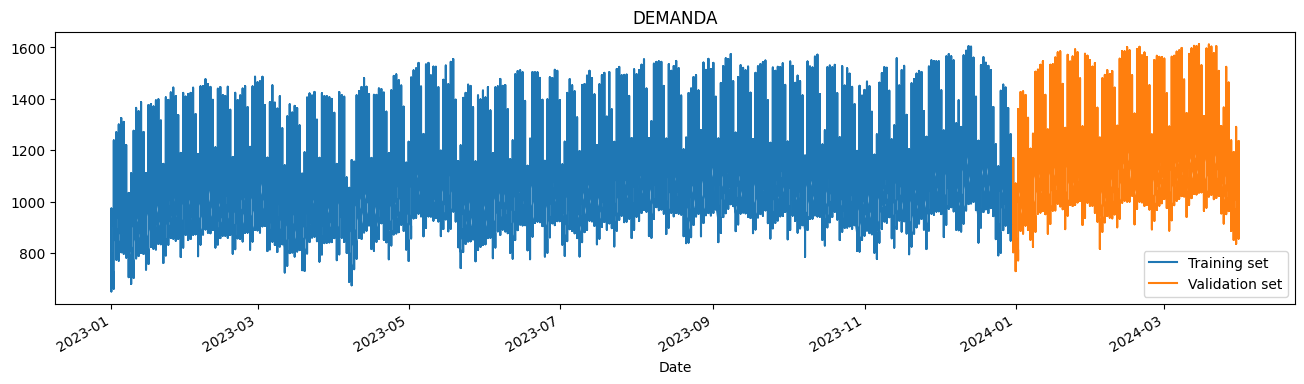

In [12]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["DEMANDA"]['2023-01-01':entrenamiento].plot(figsize=(16,4),legend=True)
#dataset["DEMANDA"][entrenamiento:validacion].plot(figsize=(16,4),legend=True)
dataset["DEMANDA"][entrenamiento:pruebas].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Validation set','Test set' ])
plt.title('DEMANDA')
plt.show()

In [13]:
# Checking for missing values
training_set = dataset[:entrenamiento].iloc[:,5:6].values
#validation_set = dataset[entrenamiento:validacion].iloc[:,5:6].values
test_set = dataset[entrenamiento:pruebas].iloc[:,5:6].values
#validation_set[np.isnan(validation_set)] = dataset['DEMANDA'].max()


## CREACION DATASET PARA REDES NEURONALES

In [14]:
#print(dataset.columns)

In [15]:
"""columnas = ['DEMANDA', 'Demanda_anterior', 'Total Residencial', 'Industrial',
            'T2M_AREA METROPOLITANA DEL VALLE DE ABURRÁ','T2M_URABA','T_DIA_2--ENE',
            'T_DIA_25-1', 'T_DIA_DOM', 'T_DIA_L-DE', 'T_DIA_LFEST',
            'T_DIA_LUN-MADLF', 'T_DIA_MAR-VIE', 'T_DIA_MV-DE',
            'T_DIA_OFEST', 'T_DIA_SAB','T_DIA_PRED_2--ENE', 'T_DIA_PRED_25-1',
            'T_DIA_PRED_DOM', 'T_DIA_PRED_L-DE', 'T_DIA_PRED_LFEST',
            'T_DIA_PRED_LUN-MADLF', 'T_DIA_PRED_MAR-VIE', 'T_DIA_PRED_MV-DE',
            'T_DIA_PRED_OFEST', 'T_DIA_PRED_SAB','HORA']
"""
columnas = ['DEMANDA','Delta_24h_PRED', 'Delta_25h_PRED','HORA','Total Residencial', 'Industrial',
            'T2M_AREA METROPOLITANA DEL VALLE DE ABURRÁ','T2M_URABA','T_DIA_2--ENE',
            'T_DIA_25-1', 'T_DIA_DOM', 'T_DIA_L-DE', 'T_DIA_LFEST',
            'T_DIA_LUN-MADLF', 'T_DIA_MAR-VIE', 'T_DIA_MV-DE',
            'T_DIA_OFEST', 'T_DIA_SAB','T_DIA_PRED_2--ENE', 'T_DIA_PRED_25-1',
            'T_DIA_PRED_DOM', 'T_DIA_PRED_L-DE', 'T_DIA_PRED_LFEST',
            'T_DIA_PRED_LUN-MADLF', 'T_DIA_PRED_MAR-VIE', 'T_DIA_PRED_MV-DE',
            'T_DIA_PRED_OFEST', 'T_DIA_PRED_SAB']
#subset = dataset[columnas]
#subset = dataset.iloc[:, 5:10]  # Selecciona desde la columna 5 hasta la columna 9 (inclusive)


In [16]:
def create_sequences(data, n_steps,n_features, steps_ahead):
    n_samples = data.shape[0]
    X, y, X_fut = [], [],[]
    for i in range(n_samples -n_steps-steps_ahead+1):
        X.append(data[i:i + n_steps,excluir_demanda:n_features])
        y.append(data[i + 1:i + n_steps + steps_ahead,0])
        X_fut.append(data[i + 1:i + n_steps + steps_ahead,excluir_demanda:n_features])
    X, y, X_fut = np.array(X), np.array(y), np.array(X_fut)
    # Reshape the X array to have the shape (n_samples, n_times, n_features)
    X = X.reshape(X.shape[0], n_steps, n_features-excluir_demanda)
    #X_fut=X_fut.reshape(X_fut.shape[0], n_steps, n_features)
    return X, y, X_fut



In [17]:
def inv_scaler(scaler, y1,y2):
  # Obtiene el mínimo y el rango para la columna seleccionada
  minimo_columna = scaler.data_min_[0]  # Suponiendo que la columna seleccionada es la primera
  rango_columna = scaler.data_range_[0]  # Suponiendo que la columna seleccionada es la primera
  rango_escala = scaler.feature_range
  # Transforma inversamente las columnas seleccionada

  y1=(y1 -rango_escala[0]) / (rango_escala[1]-rango_escala[0])
  y2=(y2 -rango_escala[0]) / (rango_escala[1]-rango_escala[0])
  y1_inv = y1 * rango_columna + minimo_columna
  y2_inv = y2 * rango_columna + minimo_columna

  return y1_inv, y2_inv


In [18]:
def metricas(y_test, y_pred):

  # Convertir los arrays 1D a 2D
  Y_test_2d = y_test.reshape(-1, 1)
  Y_pred_2d = y_pred.reshape(-1, 1)
  #porcentaje_desviacion = porcentaje_desviacion.reshape(-1, 1)

  r2 = r2_score(Y_test_2d, Y_pred_2d)
  mse = mean_squared_error(y_true=Y_test_2d, y_pred=Y_pred_2d, squared=True)
  rmse = mean_squared_error(y_true=Y_test_2d, y_pred=Y_pred_2d, squared=False)
  mae = mean_absolute_error(y_true=Y_test_2d, y_pred=Y_pred_2d)
  mape=mean_absolute_percentage_error(y_true=Y_test_2d, y_pred=Y_pred_2d)
  print(f"r2:{r2}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"MAPE: {mape}")

  # Calcular la diferencia absoluta entre los valores de Y_test y Y_pred
  diferencia_absoluta = np.abs(Y_test_2d - Y_pred_2d)

  # Calcular el porcentaje de desviación
  porcentaje_desviacion = (diferencia_absoluta / Y_test_2d) * 100



  print('shapes:', Y_test_2d.shape, Y_pred_2d.shape, porcentaje_desviacion.shape)

  # Crear el DataFrame
  results= pd.DataFrame({'y_test': Y_test_2d.flatten(),
                    'y_pred': Y_pred_2d.flatten(),
                    '%error': porcentaje_desviacion.flatten()})

  # Imprimir el DataFrame
  print(results.head())
  return results,rmse

In [19]:


def graficar_pred(results, titulo="Gráfico pronóstico demanda"):
  # Create traces
  trace_real = go.Scatter(x=results.index, y=results['y_test'], mode='lines', name='Demanda Real', line=dict(color='red'))
  trace_pred = go.Scatter(x=results.index, y=results['y_pred'], mode='lines', name='Predicción demanda', line=dict(color='blue'))

  # Create layout
  layout = go.Layout(title=titulo,
                    xaxis=dict(title='Time'),
                    yaxis=dict(title='Demanda'))

  # Create figure
  fig = go.Figure(data=[trace_real, trace_pred], layout=layout)

  # Display interactive plot
  fig.show()



In [20]:
"""
def create_sequences(data, n_steps,n_features, steps_ahead):
    n_samples, n_features = data.shape
    X, y = [], []
    for i in range(n_samples - n_steps-steps_ahead+1):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps:i + n_steps + steps_ahead,0])
    X, y = np.array(X), np.array(y)
    # Reshape the X array to have the shape (n_samples, n_times, n_features)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y
"""

'\ndef create_sequences(data, n_steps,n_features, steps_ahead):\n    n_samples, n_features = data.shape\n    X, y = [], []\n    for i in range(n_samples - n_steps-steps_ahead+1):\n        X.append(data[i:i + n_steps])\n        y.append(data[i + n_steps:i + n_steps + steps_ahead,0])\n    X, y = np.array(X), np.array(y)\n    # Reshape the X array to have the shape (n_samples, n_times, n_features)\n    X = X.reshape(X.shape[0], n_steps, n_features)\n    return X, y\n'

In [21]:
"""
def create_sequences(data, n_steps,n_features, steps_ahead):
    n_samples, n_features = data.shape
    X, y = [], []
    for i in range((n_samples - n_steps-steps_ahead)//24 + 1):
        X.append(data[i*24:i*24 + n_steps])
        y.append(data[i*24 + n_steps:i*24 + n_steps + steps_ahead,0])
    X, y = np.array(X), np.array(y)
    # Reshape the X array to have the shape (n_samples, n_times, n_features)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y
"""

'\ndef create_sequences(data, n_steps,n_features, steps_ahead):\n    n_samples, n_features = data.shape\n    X, y = [], []\n    for i in range((n_samples - n_steps-steps_ahead)//24 + 1):\n        X.append(data[i*24:i*24 + n_steps])\n        y.append(data[i*24 + n_steps:i*24 + n_steps + steps_ahead,0])\n    X, y = np.array(X), np.array(y)\n    # Reshape the X array to have the shape (n_samples, n_times, n_features)\n    X = X.reshape(X.shape[0], n_steps, n_features)\n    return X, y\n'

In [22]:
# Suponiendo que dataset es tu DataFrame original con la columna 'DEMANDA'
datos = dataset[columnas]
#datos['DEMANDA'] = pd.DataFrame({'DEMANDA': np.arange(0, 28392 )})  # Corregir esta línea
#datos['DEMANDA'] = np.arange(0, 28392 )  # Corregir esta línea


# Normalizar los datos usando MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
datos = sc.fit_transform(datos)

#datos = sc.fit_transform(datos.values.reshape(-1, 1))


Xtt, Ytt, Xtt_fut = create_sequences(np.array(datos), n_steps = lookback,steps_ahead=steps_ahead+blackout,n_features =features)

Xtt.shape, Ytt.shape, Xtt_fut.shape

((27889, 168, 27), (27889, 503), (27889, 503, 27))

In [23]:
datos

array([[0.27598611, 0.5174784 , 0.55662029, ..., 0.        , 0.        ,
        0.        ],
       [0.24357629, 0.49627684, 0.5174784 , ..., 0.        , 0.        ,
        0.        ],
       [0.23073118, 0.48664897, 0.49627684, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.59471909, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53947476, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4609959 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
Xtt

array([[[0.5174784 , 0.55662029, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.49627684, 0.5174784 , 0.04347826, ..., 0.        ,
         0.        , 0.        ],
        [0.48664897, 0.49627684, 0.08695652, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.64938212, 0.68392272, 0.91304348, ..., 0.        ,
         0.        , 0.        ],
        [0.61052191, 0.64938212, 0.95652174, ..., 0.        ,
         0.        , 0.        ],
        [0.55662029, 0.61052191, 1.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.49627684, 0.5174784 , 0.04347826, ..., 0.        ,
         0.        , 0.        ],
        [0.48664897, 0.49627684, 0.08695652, ..., 0.        ,
         0.        , 0.        ],
        [0.48576512, 0.48664897, 0.13043478, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.61052191, 0.64938212, 0.95652174, ..., 0.        ,
         0.        , 0.        ],
        [0.5

In [25]:
Xtt_fut

array([[[0.49627684, 0.5174784 , 0.04347826, ..., 0.        ,
         0.        , 0.        ],
        [0.48664897, 0.49627684, 0.08695652, ..., 0.        ,
         0.        , 0.        ],
        [0.48576512, 0.48664897, 0.13043478, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.67586742, 0.71057413, 0.91304348, ..., 0.        ,
         0.        , 0.        ],
        [0.63714756, 0.67586742, 0.95652174, ..., 0.        ,
         0.        , 0.        ],
        [0.58575194, 0.63714756, 1.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.48664897, 0.49627684, 0.08695652, ..., 0.        ,
         0.        , 0.        ],
        [0.48576512, 0.48664897, 0.13043478, ..., 0.        ,
         0.        , 0.        ],
        [0.5142816 , 0.48576512, 0.17391304, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.63714756, 0.67586742, 0.95652174, ..., 0.        ,
         0.        , 0.        ],
        [0.5

In [26]:
Ytt

array([[0.24357629, 0.23073118, 0.23488738, ..., 0.54680974, 0.48788686,
        0.41383448],
       [0.23073118, 0.23488738, 0.26894937, ..., 0.48788686, 0.41383448,
        0.36739193],
       [0.23488738, 0.26894937, 0.32449456, ..., 0.41383448, 0.36739193,
        0.3340078 ],
       ...,
       [0.56781713, 0.51813192, 0.48564607, ..., 0.68058773, 0.64452141,
        0.59471909],
       [0.51813192, 0.48564607, 0.47001231, ..., 0.64452141, 0.59471909,
        0.53947476],
       [0.48564607, 0.47001231, 0.47435113, ..., 0.59471909, 0.53947476,
        0.4609959 ]])

## DATASET ENTRENAMIENTO Y PRUEBA

In [27]:
datos.shape

(28392, 28)

In [28]:
semanas_test=13

In [29]:
X_train, Y_train, X_train_fut = Xtt[:Xtt.shape[0]-semanas_test*24*7, :lookback,:features], Ytt[:Ytt.shape[0]-semanas_test*24*7, -steps_ahead:],Xtt_fut[:Xtt_fut.shape[0]-semanas_test*24*7, -steps_ahead:]
#X_valid, Y_valid = Xtt[Xtt.shape[0]-4368:Xtt.shape[0]-2184, :lookback,:features], Ytt[Ytt.shape[0]-4368:Ytt.shape[0]-2184, -steps_ahead:]
X_test, Y_test, X_test_fut = Xtt[Xtt.shape[0]-semanas_test*24*7:, :lookback,:features], Ytt[Ytt.shape[0]-semanas_test*24*7:, -steps_ahead:],Xtt_fut[Xtt_fut.shape[0]-semanas_test*24*7:, -steps_ahead:]

X_train.shape, Y_train.shape,X_train_fut.shape, X_test.shape, Y_test.shape, X_test_fut.shape

((25705, 168, 27),
 (25705, 168),
 (25705, 168, 27),
 (2184, 168, 27),
 (2184, 168),
 (2184, 168, 27))

In [30]:
X_train2, Y_train2 = Xtt[:Xtt.shape[0]-semanas_test*24*7, :lookback,:features], Ytt[:Ytt.shape[0]-semanas_test*24*7, -steps_ahead:-steps_ahead+1]
#X_valid2, Y_valid2 = Xtt[Xtt.shape[0]-4368:Xtt.shape[0]-2184, :lookback,:features], Ytt[Ytt.shape[0]-4368:Ytt.shape[0]-2184, -steps_ahead:-steps_ahead+1]
X_test2, Y_test2, X_test2_fut = Xtt[Xtt.shape[0]-semanas_test*24*7:, :lookback,:features], Ytt[Ytt.shape[0]-semanas_test*24*7:, -steps_ahead:],Xtt_fut[Xtt_fut.shape[0]-semanas_test*24*7:, -blackout-steps_ahead:-steps_ahead]

X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape, X_test2_fut.shape

((25705, 168, 27), (25705, 1), (2184, 168, 27), (2184, 168), (2184, 168, 27))

In [31]:
X_train3 = Xtt[:Xtt.shape[0]-semanas_test*24*7, :lookback]
#X_valid3 = Xtt[Xtt.shape[0]-4368:Xtt.shape[0]-2184, :lookback]
X_test3 = Xtt[Xtt.shape[0]-semanas_test*24*7:, :lookback]

Ytt_3 = np.expand_dims(Ytt, axis=-1)

Y = np.empty((Ytt.shape[0], lookback, steps_ahead))
for step_ahead in range(0, steps_ahead):
    Y[:,:, step_ahead] = Ytt_3[:, step_ahead+blackout:step_ahead+blackout + lookback, 0]
    #print("iteración",step_ahead)
    #print(dataset_reshaped[..., step_ahead:step_ahead + lookback, 0])
    #print("Y",Y)
Y_train3 = Y[:Ytt.shape[0]-semanas_test*24*7]
#Y_valid3 = Y[Ytt.shape[0]-4368:Ytt.shape[0]-2184]
Y_test3 = Y[Ytt.shape[0]-semanas_test*24*7:]

X_train3.shape, Y_train3.shape,X_test3.shape, Y_test3.shape

((25705, 168, 27), (25705, 168, 168), (2184, 168, 27), (2184, 168, 168))

# MODELOS REDES NEURONALES

## RNN

### SECUENCIA A VECTOR

#### Modelo

In [ ]:
#epochs=5
model = keras.models.Sequential([
  keras.layers.SimpleRNN(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.SimpleRNN(48,activation = 'sigmoid'),
  keras.layers.Dense(24,activation = 'sigmoid'),
  keras.layers.Dense(12,activation = 'sigmoid'),
  keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam',loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


# Entrenar el modelo
history=model.fit(X_train2, Y_train2, epochs=epochs,batch_size=batch_size, validation_data=(X_test2, Y_test2), callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 129s 50ms/step - loss: 0.0075 - val_loss: 0.0304
Epoch 2/30
2571/2571 [==============================] - 127s 49ms/step - loss: 0.0026 - val_loss: 0.0316
Epoch 3/30
2571/2571 [==============================] - 128s 50ms/step - loss: 0.0022 - val_loss: 0.0282
Epoch 4/30
2571/2571 [==============================] - 128s 50ms/step - loss: 0.0019 - val_loss: 0.0318
Epoch 5/30
2571/2571 [==============================] - 127s 49ms/step - loss: 0.0017 - val_loss: 0.0278
Epoch 6/30
2571/2571 [==============================] - 129s 50ms/step - loss: 0.0016 - val_loss: 0.0300
Epoch 7/30
2571/2571 [==============================] - 131s 51ms/step - loss: 0.0016 - val_loss: 0.0289
Epoch 8/30
2571/2571 [==============================] - 127s 50ms/step - loss: 0.0015 - val_loss: 0.0289
Epoch 9/30
2571/2571 [==============================] - 128s 50ms/step - loss: 0.0014 - val_loss: 0.0296
Epoch 10/30
2571/2571 [==============================] 

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new2 = X_test2[steps_ahead-1::steps_ahead]
Y_test_new2 = Y_test2[steps_ahead-1::steps_ahead]
X_fut_new2 = X_test2_fut[steps_ahead-1::steps_ahead]
X_test_new2.shape, Y_test_new2.shape, X_fut_new2.shape


((13, 168, 27), (13, 168), (13, 168, 27))

In [ ]:
X, Y_new, X_fut = X_test_new2.copy(), Y_test_new2.copy(), X_fut_new2.copy()
print("shapes:",X.shape, Y_new.shape, X_fut.shape)

Y_pred=[]
for step_ahead in range(steps_ahead):
  y_pred_one = model.predict(X[:,step_ahead:])
  #X_fut[0,step_ahead,0]=y_pred_one
  Y_pred=np.append(Y_pred,y_pred_one)
  X_fut_first_pos = X_fut[:,step_ahead:step_ahead+1,:]
  X = np.concatenate([X, X_fut_first_pos], axis=1)


print("y_pred", Y_pred)

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
Y_pred_inv = Y_pred_inv.reshape((1, Y_pred_inv.shape[0]))
resultados,rmse=metricas(Y_test_inv,Y_pred_inv)

shapes: (13, 168, 27) (13, 168) (13, 168, 27)
1/1 [==============================] - 0s 28ms/step
y_pred [0.49017799 0.4520348  0.47579119 ... 0.59442812 0.50658053 0.0845127 ]
r2:-1.397549397458663
MSE: 115175.41272142563
RMSE: 339.375032554585
MAE: 265.84186117597454
MAPE: 0.21460800733054206
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test       y_pred     %error
0  881.82599  1012.206339  14.785269
1  849.93100   967.256472  13.804117
2  809.63944   995.252201  22.925361
3  782.66869   997.374537  27.432533
4  761.60659  1011.094106  32.758056


#### Gráfico resultado

In [ ]:
graficar_pred(resultados,'Predicción demanda horaria usando Simple RNN - Secuence to Vector 1 step')


### SECUENCIA A VECTOR - PREDICCION SIMULTANEA

#### Modelo

In [ ]:
#epochs=1
model = keras.models.Sequential([
  keras.layers.SimpleRNN(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.SimpleRNN(48,activation = 'sigmoid'),
  keras.layers.Dense(96,activation = 'sigmoid'),
  keras.layers.Dense(192,activation = 'sigmoid'),
  keras.layers.Dense(steps_ahead)
])


# Compilar el modelo
model.compile(optimizer='adam',loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 133s 51ms/step - loss: 0.0201 - val_loss: 0.0232
Epoch 2/30
2571/2571 [==============================] - 132s 51ms/step - loss: 0.0083 - val_loss: 0.0157
Epoch 3/30
2571/2571 [==============================] - 130s 51ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 4/30
2571/2571 [==============================] - 131s 51ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 5/30
2571/2571 [==============================] - 131s 51ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 6/30
2571/2571 [==============================] - 131s 51ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 7/30
2571/2571 [==============================] - 130s 50ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 8/30
2571/2571 [==============================] - 129s 50ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 9/30
2571/2571 [==============================] - 129s 50ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 10/30
2571/2571 [==============================] 

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape, Y_test_new.shape

((13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict(X_test_new)
Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred)
resultados, rmse =metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 193ms/step
r2:0.842782307447521
MSE: 7552.550385837951
RMSE: 86.90541056710998
MAE: 63.95714965491216
MAPE: 0.05261681327825995
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  922.614624   4.625474
1  849.93100  866.196777   1.913776
2  809.63944  826.555542   2.089338
3  782.66869  817.076172   4.396175
4  761.60659  838.102417  10.044008


#### Gráfico resultado

In [ ]:
graficar_pred(resultados,'Predicción demanda horaria usando Simple RNN - Secuence to Vector multiple step')


In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/simpleRNN_S2V_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

### SECUENCIA A SECUENCIA

#### Modelo

In [ ]:

#epochs=10
model = keras.models.Sequential([
    keras.layers.SimpleRNN(48, activation = 'sigmoid',return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
    keras.layers.SimpleRNN(48, activation = 'sigmoid',return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(96,activation = 'sigmoid')),
    keras.layers.Dense(192,activation = 'sigmoid'),
    keras.layers.Dense(steps_ahead)
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="huber_loss", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history=model.fit(X_train3, Y_train3, epochs=epochs,batch_size=batch_size, validation_data=(X_test3, Y_test3),callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 151s 58ms/step - loss: 0.0083 - last_time_step_mse: 0.0166 - val_loss: 0.0050 - val_last_time_step_mse: 0.0098
Epoch 2/30
2571/2571 [==============================] - 149s 58ms/step - loss: 0.0025 - last_time_step_mse: 0.0050 - val_loss: 0.0042 - val_last_time_step_mse: 0.0084
Epoch 3/30
2571/2571 [==============================] - 151s 59ms/step - loss: 0.0019 - last_time_step_mse: 0.0038 - val_loss: 0.0039 - val_last_time_step_mse: 0.0075
Epoch 4/30
2571/2571 [==============================] - 150s 58ms/step - loss: 0.0016 - last_time_step_mse: 0.0029 - val_loss: 0.0030 - val_last_time_step_mse: 0.0057
Epoch 5/30
2571/2571 [==============================] - 153s 60ms/step - loss: 0.0016 - last_time_step_mse: 0.0030 - val_loss: 0.0029 - val_last_time_step_mse: 0.0054
Epoch 6/30
2571/2571 [==============================] - 149s 58ms/step - loss: 0.0016 - last_time_step_mse: 0.0029 - val_loss: 0.0027 - val_last_time_step_mse: 0.005

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new3 = X_test3[steps_ahead-1::steps_ahead]
Y_test_new3 = Y_test3[steps_ahead-1::steps_ahead]
X_test_new3.shape, Y_test_new3.shape

((13, 168, 27), (13, 168, 168))

In [ ]:
X_new, Y_new = X_test_new3, Y_test_new3[:, -1][..., np.newaxis]

Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
resultados,rmse =metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 32ms/step
r2:0.8598893519477276
MSE: 6730.748377152095
RMSE: 82.0411383218937
MAE: 63.85665612344036
MAPE: 0.052640225048808366
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  946.648071   7.350893
1  849.93100  901.101379   6.020533
2  809.63944  872.457520   7.758772
3  782.66869  860.474854   9.941137
4  761.60659  871.140259  14.381922


#### Gráfico resultado

In [ ]:
graficar_pred(resultados,'Predicción demanda horaria usando Simple RNN - Secuence to secuence multiple step')

In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/simpleRNN_S2S_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

## LSTM

### SECUENCIA A VECTOR

#### Modelo

In [ ]:
#epochs=1
model = keras.models.Sequential([
  keras.layers.LSTM(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.LSTM(48,activation = 'sigmoid'),
  keras.layers.Dense(24,activation = 'sigmoid'),
  keras.layers.Dense(12,activation = 'sigmoid'),
  keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam',loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
# Entrenar el modelo
history=model.fit(X_train2, Y_train2, epochs=epochs,batch_size=batch_size, validation_data=(X_test2, Y_test2),callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 240s 93ms/step - loss: 0.0052 - val_loss: 0.0321
Epoch 2/30
2571/2571 [==============================] - 237s 92ms/step - loss: 0.0023 - val_loss: 0.0316
Epoch 3/30
2571/2571 [==============================] - 238s 92ms/step - loss: 0.0020 - val_loss: 0.0316
Epoch 4/30
2571/2571 [==============================] - 238s 92ms/step - loss: 0.0018 - val_loss: 0.0295
Epoch 5/30
2571/2571 [==============================] - 238s 93ms/step - loss: 0.0016 - val_loss: 0.0310
Epoch 6/30
2571/2571 [==============================] - 236s 92ms/step - loss: 0.0014 - val_loss: 0.0303
Epoch 7/30
2571/2571 [==============================] - 238s 92ms/step - loss: 0.0013 - val_loss: 0.0293
Epoch 8/30
2571/2571 [==============================] - 238s 93ms/step - loss: 0.0012 - val_loss: 0.0310
Epoch 9/30
2571/2571 [==============================] - 237s 92ms/step - loss: 9.7953e-04 - val_loss: 0.0320
Epoch 10/30
2571/2571 [============================

In [ ]:
Y_test_inv.shape,Y_pred_inv.shape

((13, 168, 1), (13, 168, 1))

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new2 = X_test2[steps_ahead-1::steps_ahead]
Y_test_new2 = Y_test2[steps_ahead-1::steps_ahead]
X_fut_new2 = X_test2_fut[steps_ahead-1::steps_ahead]
X_test_new2.shape, Y_test_new2.shape, X_fut_new2.shape

((13, 168, 27), (13, 168), (13, 168, 27))

In [ ]:
X, Y_new, X_fut = X_test_new2.copy(), Y_test_new2.copy(), X_fut_new2.copy()
print("shapes:",X.shape, Y_new.shape, X_fut.shape)

Y_pred=[]

for step_ahead in range(steps_ahead):
  y_pred_one = model.predict(X[:,step_ahead:])
  #X_fut[0,step_ahead,0]=y_pred_one
  Y_pred=np.append(Y_pred,y_pred_one)
  X_fut_first_pos = X_fut[:,step_ahead:step_ahead+1,:]
  X = np.concatenate([X, X_fut_first_pos], axis=1)
print("y_pred", Y_pred)

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
Y_pred_inv = Y_pred_inv.reshape((1, Y_pred_inv.shape[0]))
resultados,rmse=metricas(Y_test_inv,Y_pred_inv)

shapes: (13, 168, 27) (13, 168) (13, 168, 27)
1/1 [==============================] - 0s 37ms/step
y_pred [0.37470597 0.35106641 0.49719122 ... 0.55290115 0.47597417 0.05681824]
r2:-1.443684209439589
MSE: 117391.67404907996
RMSE: 342.624683945976
MAE: 268.80517237921595
MAPE: 0.2192938474830356
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test       y_pred     %error
0  881.82599   876.128254   0.646129
1  849.93100   848.270198   0.195404
2  809.63944  1020.471087  26.040190
3  782.66869  1003.358098  28.197041
4  761.60659  1017.988589  33.663312


#### Gráfico resultado

In [ ]:
graficar_pred(resultados,'Predicción demanda horaria usando LSTM - Secuence to Vector 1 step')

### SECUENCIA A VECTOR - PREDICCION SIMULTANEA

#### Modelo

In [ ]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
#X_valid = X_valid.astype(np.float32)
#Y_valid = Y_valid.astype(np.float32)

In [ ]:
#epochs=30
model = keras.models.Sequential([
  keras.layers.LSTM(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.LSTM(48,activation = 'sigmoid'),
  keras.layers.Dense(96,activation = 'sigmoid'),
  keras.layers.Dense(192,activation = 'sigmoid'),
  keras.layers.Dense(steps_ahead)
])

# Compilar el modelo
model.compile(optimizer='adam',loss='huber_loss')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history=model.fit(X_train, Y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_test, Y_test),callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 825s 319ms/step - loss: 0.0102 - val_loss: 0.0133
Epoch 2/30
2571/2571 [==============================] - 814s 316ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 3/30
2571/2571 [==============================] - 804s 313ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/30
2571/2571 [==============================] - 803s 312ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/30
2571/2571 [==============================] - 799s 311ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/30
2571/2571 [==============================] - 795s 309ms/step - loss: 9.1646e-04 - val_loss: 0.0014
Epoch 7/30
2571/2571 [==============================] - 795s 309ms/step - loss: 8.2158e-04 - val_loss: 0.0012
Epoch 8/30
2571/2571 [==============================] - 792s 308ms/step - loss: 7.4495e-04 - val_loss: 0.0010
Epoch 9/30
2571/2571 [==============================] - 808s 314ms/step - loss: 6.9888e-04 - val_loss: 9.2672e-04
Epoch 10/30
2571/2571 [===

In [ ]:
#model.evaluate(X_test,Y_test)

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape, Y_test_new.shape


((13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict(X_test_new)
Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 332ms/step
r2:0.9288588776378084
MSE: 3417.534645257347
RMSE: 58.45968393052897
MAE: 43.361122131553344
MAPE: 0.036418161216174236
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred    %error
0  881.82599  804.961792  8.716481
1  849.93100  771.583374  9.218116
2  809.63944  742.897156  8.243458
3  782.66869  738.439087  5.651127
4  761.60659  748.208862  1.759140


#### Gráfico resultado

In [ ]:
graficar_pred(resultados, 'Predicción demanda horaria usando LSTM - Secuence to Vector multiple step')

In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/LSTM_S2V_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

NameError: name 'resultados' is not defined

### SECUENCIA A SECUENCIA

#### Modelo

In [ ]:
#epochs=10

inicio = time.time()


model = keras.models.Sequential([
    keras.layers.LSTM(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
    keras.layers.LSTM(48,activation = 'sigmoid', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(96,activation = 'sigmoid')),
    keras.layers.Dense(192,activation = 'sigmoid'),
    keras.layers.Dense(steps_ahead)
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="huber_loss", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history=model.fit(X_train3, Y_train3, epochs=epochs,batch_size=batch_size, validation_data=(X_test3, Y_test3),callbacks=[early_stopping])

fin = time.time()

# Calcular la duración de la operación
duracion = fin - inicio
print(f"La operación tomó {duracion} segundos.")

Epoch 1/30
2571/2571 [==============================] - 803s 310ms/step - loss: 0.0079 - last_time_step_mse: 0.0155 - val_loss: 0.0043 - val_last_time_step_mse: 0.0075
Epoch 2/30
2571/2571 [==============================] - 799s 311ms/step - loss: 0.0019 - last_time_step_mse: 0.0033 - val_loss: 0.0020 - val_last_time_step_mse: 0.0029
Epoch 3/30
2571/2571 [==============================] - 797s 310ms/step - loss: 0.0011 - last_time_step_mse: 0.0016 - val_loss: 0.0019 - val_last_time_step_mse: 0.0026
Epoch 4/30
2571/2571 [==============================] - 796s 310ms/step - loss: 0.0010 - last_time_step_mse: 0.0013 - val_loss: 0.0018 - val_last_time_step_mse: 0.0024
Epoch 5/30
2571/2571 [==============================] - 797s 310ms/step - loss: 9.1841e-04 - last_time_step_mse: 0.0011 - val_loss: 0.0018 - val_last_time_step_mse: 0.0027
Epoch 6/30
2571/2571 [==============================] - 795s 309ms/step - loss: 8.4877e-04 - last_time_step_mse: 9.5449e-04 - val_loss: 0.0016 - val_last_ti

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new3 = X_test3[steps_ahead-1::steps_ahead]
Y_test_new3 = Y_test3[steps_ahead-1::steps_ahead]
X_test_new3.shape, Y_test_new3.shape

((13, 168, 27), (13, 168, 168))

In [ ]:
inico = time.time()
X_new, Y_new = X_test_new3, Y_test_new3[:, -1][..., np.newaxis]

Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
resultados,rmse=metricas(Y_test_inv,Y_pred_inv)
fin = time.time()

# Calcular la duración de la operación
duracion = fin - inicio
print(f"La operación tomó {duracion} segundos.")

1/1 [==============================] - 0s 425ms/step
r2:0.9168357951527983
MSE: 3995.1091840187164
RMSE: 63.20687608178968
MAE: 43.59411160635589
MAPE: 0.03628364317134647
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  917.983704   4.100323
1  849.93100  876.574463   3.134780
2  809.63944  847.186523   4.637507
3  782.66869  837.872803   7.053318
4  761.60659  859.278076  12.824401


#### Gráfico resultado

In [ ]:
graficar_pred(resultados, 'Predicción demanda horaria usando LSTM - Secuence to secuence multiple step')

In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/LSTM_S2S_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

## GRU

### SECUENCIA A VECTOR  - PREDICCION UNO A UNO

#### Modelo

In [ ]:
#epochs=10
model = keras.models.Sequential([
  keras.layers.GRU(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.GRU(48,activation = 'sigmoid'),
  keras.layers.Dense(24,activation = 'sigmoid'),
  keras.layers.Dense(12,activation = 'sigmoid'),
  keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam',loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
# Entrenar el modelo
history=model.fit(X_train2, Y_train2, epochs=epochs,batch_size=batch_size, validation_data=(X_test2, Y_test2),callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 234s 90ms/step - loss: 0.0064 - val_loss: 0.0356
Epoch 2/30
2571/2571 [==============================] - 232s 90ms/step - loss: 0.0023 - val_loss: 0.0306
Epoch 3/30
2571/2571 [==============================] - 234s 91ms/step - loss: 0.0020 - val_loss: 0.0301
Epoch 4/30
2571/2571 [==============================] - 234s 91ms/step - loss: 0.0017 - val_loss: 0.0257
Epoch 5/30
2571/2571 [==============================] - 234s 91ms/step - loss: 0.0016 - val_loss: 0.0302
Epoch 6/30
2571/2571 [==============================] - 234s 91ms/step - loss: 8.2831e-04 - val_loss: 0.0293
Epoch 7/30
2571/2571 [==============================] - 240s 93ms/step - loss: 5.9265e-04 - val_loss: 0.0312
Epoch 8/30
2571/2571 [==============================] - 237s 92ms/step - loss: 5.1624e-04 - val_loss: 0.0305
Epoch 9/30
2571/2571 [==============================] - 240s 94ms/step - loss: 4.8214e-04 - val_loss: 0.0306


In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new2 = X_test2[steps_ahead-1::steps_ahead]
Y_test_new2 = Y_test2[steps_ahead-1::steps_ahead]
X_fut_new2 = X_test2_fut[steps_ahead-1::steps_ahead]
X_test_new2.shape, Y_test_new2.shape, X_fut_new2.shape

((13, 168, 27), (13, 168), (13, 168, 27))

In [ ]:
X, Y_new, X_fut = X_test_new2.copy(), Y_test_new2.copy(), X_fut_new2.copy()
print("shapes:",X.shape, Y_new.shape, X_fut.shape)

Y_pred=[]
for step_ahead in range(steps_ahead):
  y_pred_one = model.predict(X[:,step_ahead:])
  #X_fut[0,step_ahead,0]=y_pred_one
  Y_pred=np.append(Y_pred,y_pred_one)
  X_fut_first_pos = X_fut[:,step_ahead:step_ahead+1,:]
  X = np.concatenate([X, X_fut_first_pos], axis=1)

print("y_pred", Y_pred)

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
Y_pred_inv = Y_pred_inv.reshape((1, Y_pred_inv.shape[0]))
resultados,rmse=metricas(Y_test_inv,Y_pred_inv)

shapes: (13, 168, 27) (13, 168) (13, 168, 27)
1/1 [==============================] - 0s 39ms/step
y_pred [0.53393489 0.50179935 0.52107012 ... 0.62267673 0.54351419 0.07505464]
r2:-1.204865298054186
MSE: 105919.09846267033
RMSE: 325.45214465827434
MAE: 256.68764573266026
MAPE: 0.20687041703191614
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test       y_pred     %error
0  881.82599  1063.771692  20.632835
1  849.93100  1025.901534  20.704097
2  809.63944  1048.611196  29.515825
3  782.66869  1050.812483  34.260192
4  761.60659  1066.711073  40.060641


#### Gráfico resultado

In [ ]:
graficar_pred(resultados, 'Predicción demanda horaria usando GRU - Secuence to Vector 1 step')


### SECUENCIA A VECTOR - PREDICCION SIMULTANEA

#### Modelo

In [ ]:
#epochs=20
inicio = time.time()

model = keras.models.Sequential([
  keras.layers.GRU(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
  keras.layers.GRU(48,activation = 'sigmoid'),
  keras.layers.Dense(96,activation = 'sigmoid'),
  keras.layers.Dense(192,activation = 'sigmoid'),
  keras.layers.Dense(steps_ahead)
])

# Compilar el modelo
model.compile(optimizer='adam',loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
# Entrenar el modelo
history=model.fit(X_train, Y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_test, Y_test),callbacks=[early_stopping])

fin = time.time()

# Calcular la duración de la operación
duracion = fin - inicio
print(f"La operación tomó {duracion} segundos.")

Epoch 1/30
2571/2571 [==============================] - 936s 362ms/step - loss: 0.0113 - val_loss: 0.0061
Epoch 2/30
2571/2571 [==============================] - 931s 362ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 3/30
2571/2571 [==============================] - 931s 362ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/30
2571/2571 [==============================] - 929s 361ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/30
2571/2571 [==============================] - 928s 361ms/step - loss: 9.8203e-04 - val_loss: 0.0011
Epoch 6/30
2571/2571 [==============================] - 929s 361ms/step - loss: 8.4231e-04 - val_loss: 9.8232e-04
Epoch 7/30
2571/2571 [==============================] - 930s 362ms/step - loss: 7.2563e-04 - val_loss: 0.0011
Epoch 8/30
2571/2571 [==============================] - 930s 362ms/step - loss: 6.4578e-04 - val_loss: 8.2210e-04
Epoch 9/30
2571/2571 [==============================] - 933s 363ms/step - loss: 5.9738e-04 - val_loss: 7.8532e-04
Epoch 10/30
25

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape, Y_test_new.shape

In [ ]:
inicio = time.time()

Y_pred = model.predict(X_test_new)
Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

fin = time.time()

# Calcular la duración de la operación
duracion = fin - inicio
print(f"La operación tomó {duracion} segundos.")

#### Gráfico resultado

In [ ]:
graficar_pred(resultados, 'Predicción demanda horaria usando GRU - Secuence to Vector multiple step')

In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/GRU_S2V_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

### SECUENCIA A SECUENCIA

#### Modelo

In [ ]:
#epochs=20
model = keras.models.Sequential([
    keras.layers.GRU(48,activation = 'sigmoid', return_sequences=True, input_shape=[lookback, features-excluir_demanda]),
    keras.layers.GRU(48,activation = 'sigmoid', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(96,activation = 'sigmoid')),
    keras.layers.Dense(192,activation = 'sigmoid'),
    keras.layers.Dense(steps_ahead)
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
#history = model.fit(X_train3, Y_train3, epochs=20,
#                    validation_data=(X_valid, Y_valid))
history=model.fit(X_train3, Y_train3, epochs=epochs,batch_size=batch_size, validation_data=(X_test3, Y_test3),callbacks=[early_stopping])

Epoch 1/30
2571/2571 [==============================] - 260s 100ms/step - loss: 0.0162 - last_time_step_mse: 0.0159 - val_loss: 0.0093 - val_last_time_step_mse: 0.0087
Epoch 2/30
2571/2571 [==============================] - 254s 99ms/step - loss: 0.0035 - last_time_step_mse: 0.0030 - val_loss: 0.0038 - val_last_time_step_mse: 0.0030
Epoch 3/30
2571/2571 [==============================] - 254s 99ms/step - loss: 0.0022 - last_time_step_mse: 0.0014 - val_loss: 0.0049 - val_last_time_step_mse: 0.0040
Epoch 4/30
2571/2571 [==============================] - 247s 96ms/step - loss: 0.0019 - last_time_step_mse: 0.0012 - val_loss: 0.0041 - val_last_time_step_mse: 0.0031
Epoch 5/30
2571/2571 [==============================] - 251s 98ms/step - loss: 0.0018 - last_time_step_mse: 0.0010 - val_loss: 0.0036 - val_last_time_step_mse: 0.0026
Epoch 6/30
2571/2571 [==============================] - 261s 102ms/step - loss: 0.0016 - last_time_step_mse: 8.9563e-04 - val_loss: 0.0036 - val_last_time_step_mse:

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new3 = X_test3[steps_ahead-1::steps_ahead]
Y_test_new3 = Y_test3[steps_ahead-1::steps_ahead]
X_test_new3.shape, Y_test_new3.shape

((13, 168, 27), (13, 168, 168))

In [ ]:
X_new, Y_new = X_test_new3, Y_test_new3[:, -1][..., np.newaxis]

Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_new,Y_pred )
resultados,rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 318ms/step
r2:0.9343789439845382
MSE: 3152.3572435286646
RMSE: 56.14585686877229
MAE: 38.73854976828105
MAPE: 0.03210175459394604
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  933.910461   5.906434
1  849.93100  900.160400   5.909821
2  809.63944  881.690491   8.899153
3  782.66869  864.839539  10.498804
4  761.60659  865.009583  13.576956


#### Gráfico resultado

In [ ]:
graficar_pred(resultados, 'Predicción demanda horaria usando GRU - Secuence to secuence multiple step')

In [ ]:
# Define el nombre del archivo CSV
nombre_archivo = '/content/drive/MyDrive/Especializacion Analitica y ciencia de datos/Semestre 2/MONOGRAFIA/Pronostico/REDES NEURONALES/TRY5/GRU_S2S_168steps_sigmoid.csv'


# Guarda el DataFrame en un archivo CSV en la ruta especificada
resultados.to_csv(nombre_archivo, index=False)  # El argumento index=False evita que se guarde el índice del DataFrame

# 2 ENTRADAS

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

## SIMPLE RNN

In [ ]:

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red Simple RNN con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])

# Capa LSTM para la primera entrada
rnn1 = keras.layers.SimpleRNN(48, activation='sigmoid', return_sequences=True)(input1)

# Capa LSTM para la segunda entrada
rnn2 = keras.layers.SimpleRNN(48, activation='sigmoid', return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(rnn1)
pool2 = GlobalMaxPooling1D()(rnn2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

# Capa densa intermedia
dense_intermediate = Dense(96, activation='sigmoid')(concat)
dense_intermediate2 = Dense(192, activation='sigmoid')(dense_intermediate)


# Capa de salida
output = Dense(steps_ahead)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=50, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test))


Epoch 1/50
2571/2571 [==============================] - 94s 36ms/step - loss: 0.0139 - val_loss: 0.0171
Epoch 2/50
2571/2571 [==============================] - 90s 35ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 3/50
2571/2571 [==============================] - 91s 36ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 4/50
2571/2571 [==============================] - 89s 35ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/50
2571/2571 [==============================] - 90s 35ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 6/50
2571/2571 [==============================] - 90s 35ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 7/50
2571/2571 [==============================] - 89s 35ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 8/50
2571/2571 [==============================] - 90s 35ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/50
2571/2571 [==============================] - 89s 35ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/50
2571/2571 [==============================] - 90s 35m

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 168, 27), (13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 224ms/step
r2:0.9131386725273865
MSE: 4172.714544189765
RMSE: 64.5965521075991
MAE: 44.775816580788195
MAPE: 0.03738977431717416
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred    %error
0  881.82599  816.619812  7.394450
1  849.93100  779.420166  8.296066
2  809.63944  749.913269  7.376885
3  782.66869  726.674988  7.154202
4  761.60659  731.643738  3.934164


In [ ]:
graficar_pred(resultados)

## LSTM

In [ ]:
X_train[:,-1:,12:22].shape


(25537, 1, 10)

In [ ]:
# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red LSTM con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])



# Capa LSTM para la primera entrada
lstm1 = keras.layers.LSTM(168, return_sequences=True)(input1)

# Capa LSTM para la segunda entrada
lstm2 = keras.layers.LSTM(168, return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(lstm1)
pool2 = GlobalMaxPooling1D()(lstm2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)

#lstm_interm=keras.layers.LSTM(48, activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(96, activation='relu')(concat)
dense_intermediate2 = Dense(192, activation='relu')(dense_intermediate)


# Capa de salida
output = Dense(steps_ahead)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test))


Epoch 1/30
246/246 [==============================] - 150s 593ms/step - loss: 0.0216 - val_loss: 0.0150
Epoch 2/30
246/246 [==============================] - 142s 579ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 3/30
246/246 [==============================] - 142s 578ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 4/30
246/246 [==============================] - 142s 579ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 5/30
246/246 [==============================] - 142s 579ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 6/30
246/246 [==============================] - 143s 581ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 7/30
246/246 [==============================] - 143s 580ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 8/30
246/246 [==============================] - 143s 583ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 9/30
246/246 [==============================] - 142s 579ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 10/30
246/246 [==============================] - 144s 584m

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 336, 23), (13, 168, 23), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 1s 788ms/step
r2:0.6181509769919651
MSE: 18343.571510493493
RMSE: 135.43844177519725
MAE: 105.80162082504329
MAPE: 0.08548610012635136
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test       y_pred     %error
0  881.82599  1018.824707  15.535799
1  849.93100   983.743591  15.743936
2  809.63944   991.053589  22.406783
3  782.66869   992.902344  26.861130
4  761.60659  1021.789185  34.162335


In [ ]:
graficar_pred(resultados)

## GRU

In [ ]:
X_test[:,-168:,13:].shape

(2184, 168, 10)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])





# Capa GRU para la primera entrada
gru1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(gru1)
pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

# Capa densa intermedia
dense_intermediate = Dense(96,activation='sigmoid')(concat)
dense_intermediate2 = Dense(192, activation='sigmoid')(dense_intermediate)


# Capa de salida
output = Dense(168)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])


Epoch 1/30
246/246 [==============================] - 113s 448ms/step - loss: 0.0222 - val_loss: 0.0232
Epoch 2/30
246/246 [==============================] - 110s 446ms/step - loss: 0.0170 - val_loss: 0.0228
Epoch 3/30
246/246 [==============================] - 110s 448ms/step - loss: 0.0156 - val_loss: 0.0196
Epoch 4/30
246/246 [==============================] - 110s 447ms/step - loss: 0.0112 - val_loss: 0.0157
Epoch 5/30
246/246 [==============================] - 110s 447ms/step - loss: 0.0059 - val_loss: 0.0115
Epoch 6/30
246/246 [==============================] - 110s 449ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 7/30
246/246 [==============================] - 110s 446ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 8/30
246/246 [==============================] - 110s 449ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 9/30
246/246 [==============================] - 111s 450ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 10/30
246/246 [==============================] - 109s 445m

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 336, 23), (13, 168, 23), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 76ms/step
r2:0.8054994707493823
MSE: 9343.573381520637
RMSE: 96.66216106378253
MAE: 69.57933667003815
MAPE: 0.058453601608336285
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  846.734497   3.979412
1  849.93100  813.341187   4.305033
2  809.63944  811.299927   0.205090
3  782.66869  802.746216   2.565265
4  761.60659  858.236572  12.687650


In [ ]:
graficar_pred(resultados)

## GRU 2

In [ ]:
pool1, pool2, concat

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])





# Capa GRU para la primera entrada
gru1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(gru1)
pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)
#lstm_intermediate = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(168,activation='sigmoid')(concat)
dense_intermediate2 = Dense(24, activation='sigmoid')(dense_intermediate)
dense_intermediate3 = Dense(168, activation='sigmoid')(dense_intermediate2)


# Capa de salida
output = Dense(168)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])


Epoch 1/30
246/246 [==============================] - 135s 536ms/step - loss: 0.0318 - val_loss: 0.0237
Epoch 2/30
246/246 [==============================] - 130s 527ms/step - loss: 0.0169 - val_loss: 0.0242
Epoch 3/30
246/246 [==============================] - 131s 531ms/step - loss: 0.0168 - val_loss: 0.0229
Epoch 4/30
246/246 [==============================] - 129s 524ms/step - loss: 0.0163 - val_loss: 0.0235
Epoch 5/30
246/246 [==============================] - 129s 524ms/step - loss: 0.0120 - val_loss: 0.0197
Epoch 6/30
246/246 [==============================] - 131s 533ms/step - loss: 0.0091 - val_loss: 0.0126
Epoch 7/30
246/246 [==============================] - 127s 516ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 8/30
246/246 [==============================] - 128s 519ms/step - loss: 0.0041 - val_loss: 0.0089
Epoch 9/30
246/246 [==============================] - 127s 515ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 10/30
246/246 [==============================] - 129s 525m

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 336, 27), (13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 405ms/step
r2:0.7957732766138447
MSE: 9810.808144214856
RMSE: 99.04952369504285
MAE: 76.30690377033612
MAPE: 0.06350397699217068
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred    %error
0  881.82599  812.286804  7.885817
1  849.93100  765.594116  9.922792
2  809.63944  762.700562  5.797504
3  782.66869  785.464722  0.357243
4  761.60659  826.614502  8.535629


In [ ]:
graficar_pred(resultados)

## GRU 3

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features-excluir_demanda])





# Capa GRU para la primera entrada
gru1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(gru1)
pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)
#lstm_intermediate = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(168,activation='sigmoid')(concat)
dense_intermediate2 = Dense(24, activation='sigmoid')(dense_intermediate)
dense_intermediate3 = Dense(168, activation='sigmoid')(dense_intermediate2)


# Capa de salida
output = Dense(168)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])


Epoch 1/30
246/246 [==============================] - 123s 488ms/step - loss: 0.0319 - val_loss: 0.0237
Epoch 2/30
246/246 [==============================] - 113s 461ms/step - loss: 0.0169 - val_loss: 0.0239
Epoch 3/30
246/246 [==============================] - 112s 454ms/step - loss: 0.0168 - val_loss: 0.0232
Epoch 4/30
246/246 [==============================] - 111s 452ms/step - loss: 0.0128 - val_loss: 0.0182
Epoch 5/30
246/246 [==============================] - 112s 456ms/step - loss: 0.0113 - val_loss: 0.0178
Epoch 6/30
246/246 [==============================] - 113s 457ms/step - loss: 0.0087 - val_loss: 0.0121
Epoch 7/30
246/246 [==============================] - 112s 455ms/step - loss: 0.0051 - val_loss: 0.0111
Epoch 8/30
246/246 [==============================] - 112s 455ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 9/30
246/246 [==============================] - 112s 456ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 10/30
246/246 [==============================] - 113s 460m

In [ ]:
X_train.shape

(25537, 336, 23)

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 336, 23), (13, 168, 23), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 357ms/step
r2:0.8359474399942779
MSE: 7880.889264135072
RMSE: 88.77437278930825
MAE: 63.13681507984204
MAPE: 0.05286398080980932
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  832.997681   5.537182
1  849.93100  781.902344   8.004021
2  809.63944  777.721558   3.942234
3  782.66869  802.213989   2.497263
4  761.60659  854.076294  12.141400


In [ ]:
graficar_pred(resultados)

## GRU 4

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])





# Capa GRU para la primera entrada
gru1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input1)
gru1_1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(gru1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(gru1_1)
pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, pool2])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)
#lstm_intermediate = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(168,activation='sigmoid')(concat)
dense_intermediate2 = Dense(24, activation='sigmoid')(dense_intermediate)
dense_intermediate3 = Dense(168, activation='sigmoid')(dense_intermediate2)


# Capa de salida
output = Dense(168)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])


Epoch 1/30
2571/2571 [==============================] - 470s 181ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 2/30
2571/2571 [==============================] - 437s 170ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/30
2571/2571 [==============================] - 424s 165ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 4/30
2571/2571 [==============================] - 428s 166ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 5/30
2571/2571 [==============================] - 422s 164ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/30
2571/2571 [==============================] - 431s 168ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 7/30
2571/2571 [==============================] - 428s 166ms/step - loss: 9.2388e-04 - val_loss: 0.0017
Epoch 8/30
2571/2571 [==============================] - 438s 170ms/step - loss: 7.9477e-04 - val_loss: 0.0016
Epoch 9/30
2571/2571 [==============================] - 439s 171ms/step - loss: 7.0320e-04 - val_loss: 0.0013
Epoch 10/30
2571/2571 [===========

In [ ]:
X_train.shape

(25705, 168, 27)

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 168, 27), (13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 72ms/step
r2:0.8890417915997664
MSE: 5330.299955810274
RMSE: 73.00890326398742
MAE: 59.236600804125885
MAPE: 0.04913653044976418
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  765.187744  13.226900
1  849.93100  724.255127  14.786597
2  809.63944  704.535645  12.981556
3  782.66869  704.055603  10.044236
4  761.60659  728.623840   4.330681


In [ ]:
graficar_pred(resultados)

## GRU 5

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, GlobalMaxPooling1D

# Datos de ejemplo
secuencia1 = X_train[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])





# Capa GRU para la primera entrada
gru1 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input1)
gru1_1 = keras.layers.GRU(168,activation='sigmoid')(gru1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(input2)
gru2_1 = keras.layers.GRU(168,activation='sigmoid')(gru2)

# Capas de reducción de dimensionalidad
#pool1 = GlobalMaxPooling1D()(gru1_1)
#pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([gru1_1, gru2_1])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)
#lstm_intermediate = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(168,activation='sigmoid')(concat)
dense_intermediate2 = Dense(24, activation='sigmoid')(dense_intermediate)
dense_intermediate3 = Dense(168, activation='sigmoid')(dense_intermediate2)


# Capa de salida
output = Dense(steps_ahead)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])


Epoch 1/30
2571/2571 [==============================] - 431s 166ms/step - loss: 0.0189 - val_loss: 0.0231
Epoch 2/30
2571/2571 [==============================] - 444s 173ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/30
2571/2571 [==============================] - 434s 169ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/30
2571/2571 [==============================] - 448s 174ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/30
2571/2571 [==============================] - 441s 171ms/step - loss: 9.2816e-04 - val_loss: 0.0013
Epoch 6/30
2571/2571 [==============================] - 429s 167ms/step - loss: 7.2113e-04 - val_loss: 0.0014
Epoch 7/30
2571/2571 [==============================] - 432s 168ms/step - loss: 6.3363e-04 - val_loss: 0.0012
Epoch 8/30
2571/2571 [==============================] - 424s 165ms/step - loss: 5.7484e-04 - val_loss: 0.0010
Epoch 9/30
2571/2571 [==============================] - 430s 167ms/step - loss: 5.3916e-04 - val_loss: 0.0013
Epoch 10/30
2571/2571 [===

In [ ]:
X_train.shape

(25705, 168, 27)

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new = X_test[steps_ahead-1::steps_ahead]
X_test_fut_new=X_test_fut[steps_ahead-1::steps_ahead]
Y_test_new = Y_test[steps_ahead-1::steps_ahead]
X_test_new.shape,X_test_fut_new.shape, Y_test_new.shape

((13, 168, 27), (13, 168, 27), (13, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 426ms/step
r2:0.9332269770038675
MSE: 3207.6963629565466
RMSE: 56.63652852141051
MAE: 39.40145289946057
MAPE: 0.03282642751115361
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred     %error
0  881.82599  821.930542   6.792207
1  849.93100  742.183350  12.677223
2  809.63944  703.735779  13.080349
3  782.66869  684.770325  12.508277
4  761.60659  701.992798   7.827373


In [ ]:
graficar_pred(resultados)

## LSTM 2


#### Modelo

In [ ]:
#epochs=10


secuencia1 = X_train3[:,:,:features-future_features-excluir_demanda]
secuencia2 = X_train_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]
y = Y_train



# Definición de la red GRU con una capa densa intermedia
input1 = Input(shape=[lookback, features-future_features-excluir_demanda])
input2 = Input(shape=[steps_ahead,future_features])





# Capa GRU para la primera entrada
lstm1 = keras.layers.LSTM(168,activation='sigmoid', return_sequences=True)(input1)
lstm1_1 = keras.layers.LSTM(168,activation='sigmoid', return_sequences=True)(lstm1)
td_lstm = keras.layers.TimeDistributed(keras.layers.Dense(96,activation = 'sigmoid'))(lstm1_1)

# Capa GRU para la segunda entrada
gru2 = keras.layers.LSTM(168,activation='sigmoid', return_sequences=True)(input2)
gru2_1 = keras.layers.LSTM(168,activation='sigmoid')(gru2)

# Capas de reducción de dimensionalidad
pool1 = GlobalMaxPooling1D()(td_lstm)
#pool2 = GlobalMaxPooling1D()(gru2)

# Concatenación de los vectores resultantes
concat = concatenate([pool1, gru2_1])

#flatten_concat = Reshape((1, pool1.shape[1] + pool2.shape[1]))(concat)
#lstm_intermediate = keras.layers.GRU(168,activation='sigmoid', return_sequences=True)(flatten_concat)

# Capa densa intermedia
dense_intermediate = Dense(168,activation='sigmoid')(concat)
dense_intermediate2 = Dense(24, activation='sigmoid')(dense_intermediate)
dense_intermediate3 = Dense(168, activation='sigmoid')(dense_intermediate2)


# Capa de salida
output = Dense(168)(dense_intermediate2)

# Definición del modelo
model = Model(inputs=[input1, input2], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='huber_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento del modelo
history=model.fit([secuencia1, secuencia2], y, epochs=epochs, batch_size=batch_size, validation_data=([X_test3[:,:,:features-future_features-excluir_demanda],X_test_fut[:,-steps_ahead:,features-future_features-excluir_demanda:]], Y_test), callbacks=[early_stopping])




Epoch 1/30
2571/2571 [==============================] - 557s 215ms/step - loss: 0.0186 - val_loss: 0.0238
Epoch 2/30
2571/2571 [==============================] - 538s 209ms/step - loss: 0.0170 - val_loss: 0.0224
Epoch 3/30
2571/2571 [==============================] - 554s 215ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 4/30
2571/2571 [==============================] - 569s 221ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 5/30
2571/2571 [==============================] - 552s 215ms/step - loss: 0.0034 - val_loss: 0.0117
Epoch 6/30
2571/2571 [==============================] - 551s 214ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 7/30
2571/2571 [==============================] - 548s 213ms/step - loss: 0.0030 - val_loss: 0.0087
Epoch 8/30
2571/2571 [==============================] - 562s 219ms/step - loss: 0.0030 - val_loss: 0.0104
Epoch 9/30
2571/2571 [==============================] - 559s 217ms/step - loss: 0.0028 - val_loss: 0.0102
Epoch 10/30
2571/2571 [=======================

In [ ]:
# Generar un nuevo arreglo tomando uno de cada steps_ahead registros
X_test_new3 = X_test3[steps_ahead-1::steps_ahead]
Y_test_new3 = Y_test3[steps_ahead-1::steps_ahead]
X_test_new3.shape, Y_test_new3.shape

((13, 168, 27), (13, 168, 168))

In [ ]:
Y_pred = model.predict([X_test_new[:,:,:features-future_features-excluir_demanda], X_test_fut_new[:,-steps_ahead:,features-future_features-excluir_demanda:]])

Y_test_inv, Y_pred_inv = inv_scaler(sc,Y_test_new,Y_pred )
resultados, rmse=metricas(Y_test_inv,Y_pred_inv)

1/1 [==============================] - 0s 443ms/step
r2:0.40780021249104614
MSE: 28448.57128373736
RMSE: 168.6670426720566
MAE: 149.63429632318852
MAPE: 0.11892441260423517
shapes: (2184, 1) (2184, 1) (2184, 1)
      y_test      y_pred    %error
0  881.82599  815.663208  7.502929
1  849.93100  793.384583  6.653060
2  809.63944  771.724365  4.682958
3  782.66869  777.710938  0.633442
4  761.60659  821.106995  7.812486


#### Gráfico resultado

In [ ]:
graficar_pred(resultados)